In [130]:
# General Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from selenium import webdriver
import main
import seaborn as sns
import chromedriver_autoinstaller
from datetime import datetime
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
from matplotlib.colors import to_rgba
import matplotlib as mpl
from collections import defaultdict
import pickle
from PIL import Image
import urllib
import mplcyberpunk

In [131]:
chromedriver_autoinstaller.install()

import warnings
warnings.filterwarnings('ignore')

## Pull Data
- Using scraper under main package

In [132]:
chromedriver_autoinstaller.install()

if __name__ == "__main__":
    driver = webdriver.Chrome()
    
# whoscored match centre url of the required match (Example: Barcelona vs Sevilla)
url = "https://www.whoscored.com/Matches/1640735/Live/England-Premier-League-2022-2023-Bournemouth-Brighton"
match_data = main.getMatchData(driver, url, close_window=True)

# Match dataframe containing info about the match
matches_df = main.createMatchesDF(match_data)

# Events dataframe      
events_df = main.createEventsDF(match_data)

# match Id
matchId = match_data['matchId']

# Information about respective teams as dictionary
home_data = matches_df['home'][matchId]
away_data = matches_df['away'][matchId]
score = matches_df['score'][matchId]
score = ' ' + score.replace(':', '-') + ' '

home_name = home_data['name']
away_name = away_data['name']
date = match_data['startDate'].split('T')[0]
date_ = datetime.strptime(date, '%Y-%m-%d').date()
date_str = date_.strftime('%d/%m/%Y')

Region: England, League: Premier League, Season: 2022/2023, Match Id: 1640735


In [133]:
home_colors = {
    'Arsenal': '#E63636',
    'Aston Villa' : '#811331',
    'Brentford' : '#E63636', 
    'Bournemouth' : '#E63636',
    'Brighton': '#2d8ce7',
    'Chelsea' : '#2D5DE7',
    'Crystal Palace' : '#E63636',
    'Everton' : '#2D5DE7', 
    'Fulham' : '#9C9C9C', 
    'Leeds' : '#9C9C9C', 
    'Leicester' : '#2d8ce7',
    'Liverpool' : '#E63636',
    'Nottingham Forest' : '#E63636',
    'Newcastle' : '#9C9C9C',
    'Man Utd' : '#E63636',
    'Man City' : '#6FC6E6',
    'Southampton' : '#E63636',
    'Tottenham' : '#9C9C9C', 
    'West Ham' : '#811331',
    'Wolves' : '#DA9D0A'
}

away_colors = {
    'Arsenal': '#757474',
    'Aston Villa' : '#6FC6E6',
    'Brentford' : '#6FC6E6', 
    'Bournemouth' : '#757474',
    'Brighton': '#FB6B07',
    'Chelsea' : '#C5C5AD',
    'Crystal Palace' : '#9C9C9C', 
    'Everton' : '#C571FA', 
    'Fulham' : '#5FE347', 
    'Leeds' : '#b4b400', 
    'Leicester' : '#757474',
    'Liverpool' : '#9C9C9C', 
    'Nottingham Forest' : '#b4b400',
    'Newcastle' : '#0202C4',
    'Man Utd' : '#9C9C9C',
    'Man City' : '#757474',
    'Southampton' : '#2d8ce7',
    'Tottenham' : '#C571FA', 
    'West Ham' : '#757474',
    'Wolves' : '#066D49'
}

In [134]:
home_color = home_colors[home_name]
away_color = home_colors[away_name]

if (home_color == away_color) or (home_color == '#6FC6E6' and away_color == '#2d8ce7') or (home_color == '#2d8ce7' and away_color == '#6FC6E6') or (home_color == '#E63636' and away_color == '#811331') or (home_color == '#811331' and away_color == '#E63636'):
    away_color = away_colors[away_name]


In [135]:
logos = {
    'Arsenal': 9825,
    'Aston Villa' : 10252,
    'Brentford' : 9937, 
    'Bournemouth' : 8678, 
    'Brighton': 10204,
    'Chelsea' : 8455,
    'Crystal Palace' : 9826, 
    'Everton' : 8668, 
    'Fulham' : 9879, 
    'Leeds' : 8463, 
    'Leicester' : 8197,
    'Liverpool' : 8650,
    'Nottingham Forest' : 10203,
    'Newcastle' : 10261,
    'Man Utd' : 10260,
    'Man City' : 8456,
    'Southampton' : 8466,
    'Tottenham' : 8586, 
    'West Ham' : 8654,
    'Wolves' : 8602
}

home_logo_code = logos[home_name]
away_logo_code = logos[away_name]

## TeamID Mapping
- Need to define our own mapping which maps Names -> ID

In [136]:
mapping = {
            'Arsenal': 13,
            'Aston Villa' : 24,
            'Brentford' : 189, 
            'Bournemouth' : 183,
            'Brighton': 211,
            'Chelsea' : 15,
            'Crystal Palace' : 162,
            'Everton' : 31, 
            'Fulham' : 170, 
            'Leeds' : 19, 
            'Leicester' : 14,
            'Liverpool' : 26,
            'Nottingham Forest' : 174,
            'Newcastle' : 23,
            'Man Utd' : 32,
            'Man City' : 167,
            'Southampton' : 18,
            'Tottenham' : 30, 
            'West Ham' : 29,
            'Wolves' : 161
        }

## Import our Season Match Data
- Keep all games involving our team
- So we can compare this game

In [137]:
teamID = mapping[home_name]
team_color = home_colors[home_name]
team_code = logos[home_name]

df1 = pd.read_csv('pl_2223_FirstHalf.csv').iloc[:,1:]
matches1 = df1[df1['teamId'] == teamID]['matchId'].unique()

df2 = pd.read_csv('pl_2223_SecondHalf.csv').iloc[:,1:]
matches2 = df2[df2['teamId'] == teamID]['matchId'].unique()


In [138]:
df1 = df1[df1['matchId'].isin(matches1)].reset_index(drop=True)
df2 = df2[df2['matchId'].isin(matches2)].reset_index(drop=True)

## Functions
- Functions that will calculate the metrics we're intereseted in
- Will just call these whilst looping over the games 

### xG/xGA
- Non-Penalty xG For and Against

In [139]:
# Info needed for function/our xg model

pitch_length_x = 100
pitch_length_y = 100

feature_cols = ['id',
                'teamId',
                'prevTeam',
                'x', 
                'y',
                'playerName', 
                'playerAssist',
                'minute', 
                'second',
                'type',
                'prevEvent',
                'isGoal',
                'shotRightFoot',
                'shotLeftFoot',
                'shotHead',
                'shotOpenPlay',
                'shotSetPiece',
                'shotCounter', 
                'penaltyScored',
                'penaltyMissed',
                'goalOwn',
                'bigChanceMissed',
                'bigChanceScored',
              ]

shot_types = ['SavedShot', 
              'MissedShots', 
              'Goal', 
              'ShotOnPost'
             ]



In [140]:
def xg_calc(df):
    df["passRecipient"] = df['playerName'].shift(-1)
    df['teamRecipient'] = df['teamId'].shift(-1)
    df['prevEvent'] = df['type'].shift(1)
    df['shotLongPass'] = df['keyPassLong'].shift(1)
    df['shotShortPass'] = df['keyPassShort'].shift(1)
    df['shotCross'] = df['keyPassCross'].shift(1)
    df['shotThroughBall'] = df['keyPassThroughball'].shift(1)
    df['playerAssist'] = df['playerName'].shift(1)
    df['prevTeam'] = df['teamId'].shift(1)

    column_to_move = df.pop("passRecipient")
    df.insert(29, "passRecipient", column_to_move)
    column_to_move = df.pop("teamRecipient")
    df.insert(27, "teamRecipient", column_to_move)
    column_to_move = df.pop('prevEvent')
    df.insert(11, "prevEvent", column_to_move)

    df_shots = df[df['type'].isin(shot_types)].reset_index(drop=True)[feature_cols]

    df_shots = df_shots[(df_shots['penaltyScored'] == False) & 
                        (df_shots['penaltyMissed'] == False) &
                        (df_shots['goalOwn'] == False)
                       ]

    df_shots['distance_to_goal'] = np.sqrt(((pitch_length_x - df_shots['x'])**2 + 
                                    (pitch_length_y - df_shots['y'])**2))
    df_shots['distance_to_center'] = abs(df_shots['y'] - pitch_length_y/2)
    df_shots['angle'] = np.absolute(np.degrees(np.arctan((abs((pitch_length_y/2) - df_shots['y'])) 
                                                         / (pitch_length_x - df_shots['x']))))


    df_shots = df_shots.drop(['prevEvent', 'penaltyScored', 'penaltyMissed', 'goalOwn', 'type'], axis=1)
    
    # Add Big Chance Column
    df_shots['bigChance'] = df_shots['bigChanceMissed'] | df_shots['bigChanceScored']
    df_shots = df_shots.drop(['bigChanceMissed', 'bigChanceScored'], axis=1)

    cat_cols = ['shotRightFoot',
            'shotLeftFoot',
            'shotHead',
            'shotOpenPlay',
            'shotSetPiece',
            'shotCounter',
            'bigChance'
           ]
    df_shots[cat_cols] *= 1
    
    X_game = df_shots.iloc[:, 10:]
    Y_game = df_shots['isGoal']
    
    # Import our xG model 
    xg_model = pickle.load(open('xgModel_XGBoost22.sav', 'rb'))
    
    
    y_pred_game = xg_model.predict_proba(X_game)
    df_pred_game = pd.DataFrame(y_pred_game, columns = ['prob_no_goal', 'prob_goal'])
    df_pred_game = pd.merge(df_shots, df_pred_game, left_index=True, right_index=True).reset_index(drop=True)

    
    return df_pred_game.groupby(['teamId'])['prob_goal'].sum()
 

### xThreat via Pass + Carry

In [141]:
def xT_pass(events_df, ID):
    zones = []
    for i in range(8):
        row = []
        for j in range(12):
            zone = i + ((j)*8)
            row.append(zone)
        zones.append(row)
    zones = np.array(zones)
    
    xT_list = []
    path = "https://karun.in/blog/data/open_xt_12x8_v1.json"
    xT = pd.read_json(path)
    xT = np.array(xT).T
    xT_rows, xT_cols = xT.shape

    x_bins = np.array(np.linspace(0,100, 13), dtype=object)
    y_bins = np.array(np.linspace(0, 100, 9), dtype=object)
    
    df_passes = events_df[(events_df['type'] == 'Pass') & 
                          (events_df['outcomeType'] == 'Successful') & 
                          (events_df['teamId'] == ID)].reset_index(drop=True)


    df_passes['x1_bin'] = pd.cut(df_passes['x'], bins=x_bins, labels=False, include_lowest=True)
    df_passes['x2_bin'] = pd.cut(df_passes['endX'], bins=x_bins, labels=False, include_lowest=True)
    df_passes['y1_bin'] = pd.cut(df_passes['y'], bins=y_bins, labels=False, include_lowest=True)
    df_passes['y2_bin'] = pd.cut(df_passes['endY'], bins=y_bins, labels=False, include_lowest=True)
    df_passes['xT_start'] = df_passes[['x1_bin', 'y1_bin']].apply(lambda x:xT[x[0]][x[1]], axis=1)
    df_passes['xT_end'] = df_passes[['x2_bin', 'y2_bin']].apply(lambda x:xT[x[0]][x[1]], axis=1)
    df_passes['xT_diff'] = df_passes['xT_end'] - df_passes['xT_start']
    df_passes['zone'] = df_passes[['x1_bin', 'y2_bin']].apply(lambda x:zones[x[1]][x[0]], axis=1)
    df_passes = df_passes[df_passes['xT_diff'] > 0].reset_index(drop=True)
    df_passes = df_passes[['x', 'y', 'x1_bin', 'y1_bin', 'zone', 'xT_diff']]
    
    xt_pass = df_passes['xT_diff'].sum()

    return xt_pass


In [142]:
def xT_carry(events_df, ID):
    zones = []
    for i in range(8):
        row = []
        for j in range(12):
            zone = i + ((j)*8)
            row.append(zone)
        zones.append(row)
    zones = np.array(zones)
    
    xT_list = []
    path = "https://karun.in/blog/data/open_xt_12x8_v1.json"
    xT = pd.read_json(path)
    xT = np.array(xT).T
    xT_rows, xT_cols = xT.shape

    x_bins = np.array(np.linspace(0,100, 13), dtype=object)
    y_bins = np.array(np.linspace(0, 100, 9), dtype=object)
    
    df_carries = pd.DataFrame()
    min_len = 3
    max_len = 60
    min_time = 1
    max_time = 12

    for idx, match_event in events_df.iterrows():
        if idx == len(events_df) - 1:
            break

        cur_team = match_event['teamId']
        idx_next = idx + 1
        events_df_next = events_df.loc[idx_next]
        take_ons = 0
        loop = True
        count = 0 

        while loop:
            next_events = events_df.loc[idx_next]

            if next_events['type'] == 'TakeOn' and next_events['outcomeType'] == 'Successful':
                take_ons += 1
                loop = True

            elif (next_events['type'] == 'TakeOn' and next_events['outcomeType'] == 'Unsuccessful') or (next_events['teamId'] != cur_team and next_events['type'] == 'Challenge' and next_events['outcomeType'] == 'Unsuccessful') or (next_events['type'] == 'Foul'):
                loop = True

            else:
                loop = False

            idx_next += 1
            count += 0 


        same_team = cur_team == next_events['teamId']
        not_ball_touch = match_event['type'] != 'BallTouch'
        dx = 105 * (match_event['endX'] - next_events['x'])/100
        dy = 68 * (match_event['endY'] - next_events['y'])/100
        min_dist = dx**2 + dy**2 >= min_len**2
        max_dist = dx**2 + dy**2 <= max_len**2
        same_period = match_event['period'] == next_events['period']

        valid_carry = same_team & not_ball_touch & min_dist & max_dist & same_period 

        if valid_carry:
            carry = pd.DataFrame()
            prev = match_event
            nxt = next_events
            carry.loc[0, 'eventId'] = prev['eventId'] + count
            carry['id'] = prev['id'] + count
            carry['teamId'] = nxt['teamId']
            carry['x'] = prev['endX']
            carry['y'] = prev['endY']
            carry['period'] = nxt['period']
            carry['type'] = carry.apply(lambda x: {'value': 99, 'displayName': 'Carry'}, axis=1)
            carry['outcomeType'] = 'Successful'
            carry['qualifiers'] = carry.apply(
                lambda x: {'type': {'value': 999, 'displayName': 'takeOns'}, 'value': str(take_ons)}, axis=1)
            carry['satisfiedEventsTypes'] = carry.apply(lambda x: [], axis=1)
            carry['isTouch'] = True
            carry['playerId'] = nxt['playerId']
            carry['playerName'] = nxt['playerName']
            carry['endX'] = nxt['x']
            carry['endY'] = nxt['y']

            df_carries = pd.concat([df_carries, carry], ignore_index=True, sort=False)
            
    df_carries1 = df_carries[df_carries['teamId'] == ID]
    df_carries1['x1_bin'] = pd.cut(df_carries1['x'], bins=x_bins, labels=False, include_lowest=True)
    df_carries1['x2_bin'] = pd.cut(df_carries1['endX'], bins=x_bins, labels=False, include_lowest=True)
    df_carries1['y1_bin'] = pd.cut(df_carries1['y'], bins=y_bins, labels=False, include_lowest=True)
    df_carries1['y2_bin'] = pd.cut(df_carries1['endY'], bins=y_bins, labels=False, include_lowest=True)
    df_carries1['xT_start'] = df_carries1[['x1_bin', 'y1_bin']].apply(lambda x:xT[x[0]][x[1]], axis=1)
    df_carries1['xT_end'] = df_carries1[['x2_bin', 'y2_bin']].apply(lambda x:xT[x[0]][x[1]], axis=1)
    df_carries1['xT_diff'] = df_carries1['xT_end'] - df_carries1['xT_start']
    df_carries1['zone'] = df_carries1[['x1_bin', 'y2_bin']].apply(lambda x:zones[x[1]][x[0]], axis=1)
    df_carries1 = df_carries1[df_carries1['xT_diff'] > 0].reset_index(drop=True)
    df_carries1 = df_carries1[['x', 'y', 'x1_bin', 'y1_bin', 'zone', 'xT_diff']]

    xt_carry = df_carries1['xT_diff'].sum()


    return xt_carry


### Box Shots  

In [143]:
def box_shots_(df, ID):
    df["passRecipient"] = df['playerName'].shift(-1)
    df['teamRecipient'] = df['teamId'].shift(-1)
    df['prevEvent'] = df['type'].shift(1)
    df['shotLongPass'] = df['keyPassLong'].shift(1)
    df['shotShortPass'] = df['keyPassShort'].shift(1)
    df['shotCross'] = df['keyPassCross'].shift(1)
    df['shotThroughBall'] = df['keyPassThroughball'].shift(1)
    df['playerAssist'] = df['playerName'].shift(1)
    df['prevTeam'] = df['teamId'].shift(1)

    column_to_move = df.pop("passRecipient")
    df.insert(29, "passRecipient", column_to_move)
    column_to_move = df.pop("teamRecipient")
    df.insert(27, "teamRecipient", column_to_move)
    column_to_move = df.pop('prevEvent')
    df.insert(11, "prevEvent", column_to_move)

    df_shots = df[df['type'].isin(shot_types)].reset_index(drop=True)[feature_cols]

    df_shots = df_shots[(df_shots['penaltyScored'] == False) & 
                        (df_shots['penaltyMissed'] == False) &
                        (df_shots['goalOwn'] == False)
                       ]

    df_shots['distance_to_goal'] = np.sqrt(((pitch_length_x - df_shots['x'])**2 + 
                                    (pitch_length_y - df_shots['y'])**2))
    df_shots['distance_to_center'] = abs(df_shots['y'] - pitch_length_y/2)
    df_shots['angle'] = np.absolute(np.degrees(np.arctan((abs((pitch_length_y/2) - df_shots['y'])) 
                                                         / (pitch_length_x - df_shots['x']))))


    df_shots = df_shots.drop(['prevEvent', 'penaltyScored', 'penaltyMissed', 'goalOwn', 'type'], axis=1)
    
    # Add Big Chance Column
    df_shots['bigChance'] = df_shots['bigChanceMissed'] | df_shots['bigChanceScored']
    df_shots = df_shots.drop(['bigChanceMissed', 'bigChanceScored'], axis=1)

    cat_cols = ['shotRightFoot',
            'shotLeftFoot',
            'shotHead',
            'shotOpenPlay',
            'shotSetPiece',
            'shotCounter',
            'bigChance'
           ]
    df_shots[cat_cols] *= 1
    
    X_game = df_shots.iloc[:, 10:]
    Y_game = df_shots['isGoal']
    
    # Import our xG model 
    xg_model = pickle.load(open('xgModel_XGBoost22.sav', 'rb'))
    
    
    y_pred_game = xg_model.predict_proba(X_game)
    df_pred_game = pd.DataFrame(y_pred_game, columns = ['prob_no_goal', 'prob_goal'])
    df_pred_game = pd.merge(df_shots, df_pred_game, left_index=True, right_index=True).reset_index(drop=True)

    boxshots = len(df_pred_game[(df_pred_game['teamId'] == ID) & 
                  (df_pred_game['x'] >= 83) & 
                  (df_pred_game['y'] >= 21.1) & 
                  (df_pred_game['y'] <= 78.9)].reset_index(drop=True)) 

    return boxshots
 

### Field Tilt  

In [144]:
def fieldTilt(events_df, mainID, oppID):    
    main_ft_val = len(events_df[(events_df['teamId'] == mainID) &
                                (events_df['type'] == 'Pass') & 
                                (events_df['x'] > 66.6) & 
                                (events_df['endX'] > 66.6)].reset_index(drop=True))

    opp_ft_val = len(events_df[(events_df['teamId'] == oppID) &
                                (events_df['type'] == 'Pass') &                           
                                (events_df['x'] > 66.6) & 
                                (events_df['endX'] > 66.6)].reset_index(drop=True))

    den = main_ft_val + opp_ft_val
    main_ft, opp_ft = (main_ft_val/den, opp_ft_val/den)
    
    return main_ft

### Box Touches and Entries  

In [145]:
def boxTouches(events_df, ID):
    box_touches = len(events_df[(events_df['teamId'] == ID) &
                                (events_df['isTouch'] == True) &
                                (events_df['x'] >= 83) &
                                (events_df['y'] >= 21.1) & 
                                (events_df['y'] <= 78.9)])
    
    return box_touches


def boxEntries(events_df, ID):
    df_carries = pd.DataFrame()
    min_len = 3
    max_len = 60
    min_time = 1
    max_time = 12

    for idx, match_event in events_df.iterrows():
        if idx == len(events_df) - 1:
            break

        cur_team = match_event['teamId']
        idx_next = idx + 1
        events_df_next = events_df.loc[idx_next]
        take_ons = 0
        loop = True
        count = 0 

        while loop:
            next_events = events_df.loc[idx_next]

            if next_events['type'] == 'TakeOn' and next_events['outcomeType'] == 'Successful':
                take_ons += 1
                loop = True

            elif (next_events['type'] == 'TakeOn' and next_events['outcomeType'] == 'Unsuccessful') or (next_events['teamId'] != cur_team and next_events['type'] == 'Challenge' and next_events['outcomeType'] == 'Unsuccessful') or (next_events['type'] == 'Foul'):
                loop = True

            else:
                loop = False

            idx_next += 1
            count += 0 


        same_team = cur_team == next_events['teamId']
        not_ball_touch = match_event['type'] != 'BallTouch'
        dx = 105 * (match_event['endX'] - next_events['x'])/100
        dy = 68 * (match_event['endY'] - next_events['y'])/100
        min_dist = dx**2 + dy**2 >= min_len**2
        max_dist = dx**2 + dy**2 <= max_len**2
        same_period = match_event['period'] == next_events['period']

        valid_carry = same_team & not_ball_touch & min_dist & max_dist & same_period 

        if valid_carry:
            carry = pd.DataFrame()
            prev = match_event
            nxt = next_events
            carry.loc[0, 'eventId'] = prev['eventId'] + count
            carry['id'] = prev['id'] + count
            carry['teamId'] = nxt['teamId']
            carry['x'] = prev['endX']
            carry['y'] = prev['endY']
            carry['period'] = nxt['period']
            carry['type'] = carry.apply(lambda x: {'value': 99, 'displayName': 'Carry'}, axis=1)
            carry['outcomeType'] = 'Successful'
            carry['qualifiers'] = carry.apply(
                lambda x: {'type': {'value': 999, 'displayName': 'takeOns'}, 'value': str(take_ons)}, axis=1)
            carry['satisfiedEventsTypes'] = carry.apply(lambda x: [], axis=1)
            carry['isTouch'] = True
            carry['playerId'] = nxt['playerId']
            carry['playerName'] = nxt['playerName']
            carry['endX'] = nxt['x']
            carry['endY'] = nxt['y']

            df_carries = pd.concat([df_carries, carry], ignore_index=True, sort=False)

    box_passes= len(events_df[(events_df['teamId'] == ID) & 
                              (events_df['type'] == 'Pass') & 
                              (events_df['outcomeType'] == 'Successful') & 
                              (events_df['endX'] >= 83) &
                              (events_df['endY'] >= 21.1) & 
                              (events_df['endY'] <= 78.9) &
                              (((events_df['x'] < 83) | (events_df['y'] > 78.9) | (events_df['y'] < 21.1)))])
    
    box_carries = len(df_carries[(df_carries['teamId'] == ID) & 
                                 (df_carries['endX'] >= 83) &
                                 (df_carries['endY'] >= 21.1) & 
                                 (df_carries['endY'] <= 78.9) &
                                 (((df_carries['x'] < 83) | (df_carries['y'] > 78.9) | (df_carries['y'] < 21.1)))])

    box_entries = box_passes + box_carries
    
    return box_entries


### PPDA   

In [146]:
def PPDA(events_df, main_id, opp_id):
    passes = len(events_df[(events_df['teamId'] == opp_id) & 
                           (events_df['type'] == 'Pass') &
                           (events_df['outcomeType'] == 'Successful') & 
                           (events_df['x'] <= 60)])
    
    defensive_actions = len(events_df[(events_df['teamId'] == main_id) & 
                                      (events_df['type'].isin(['Tackle', 'Challenge', 'Interception', 
                                                               'Foul',])) & 
                                      (events_df['x'] >= 40)])
    
    home_ppda = round(passes/defensive_actions,2)
    
    return home_ppda

### Opp Buildup %

In [147]:
def OPP_BUILDUP(events_df, opp_id):
    total_passes = len(events_df[(events_df['teamId'] == opp_id) & 
                                 (events_df['type'] == 'Pass') &
                                 (events_df['x'] <= 60)])

    passes = len(events_df[(events_df['teamId'] == opp_id) & 
                           (events_df['type'] == 'Pass') &
                           (events_df['outcomeType'] == 'Successful') & 
                           (events_df['x'] <= 60)])
    
    opp_buildup = round(passes/total_passes, 4)
    
    return opp_buildup

### Avg Pass Sequence Length  

In [148]:
def AVG_SEQ_LEN(events_df, main_id):
    seq_list = []
    seq = 0
    count = 0
    flag = False

    for i in range(len(events_df)):
        if (events_df['teamId'][i] == main_id):
            if (events_df['type'][i] == 'Pass') and (events_df['outcomeType'][i] == 'Successful'):
                count += 1

            if count >= 10 and flag == False:
                seq += 1
                flag = True


        else:
            seq_list.append(count)
            count = 0
            flag = False

    avg_seq = round(np.mean([x for x in seq_list if x > 0]),2)
    
    return avg_seq


### Duels Won

In [149]:
def DUELS_WON(events_df, main_id):
    
    duels = events_df[(events_df['type'].isin(['Foul', 'TakeOn', 'Tackle', 'Aerial'])) & 
                      (events_df['teamId'] == main_id)]
    
    duels_won = len(duels[duels['outcomeType'] == 'Successful'])
    
    return duels_won

### Defensive Action Height  

In [150]:
def DEF_ACTION_HEIGHT(events_df, main_id):
    defensive_actions = events_df[(events_df['type'].isin(['Tackle', 'Interception', 'BlockedPass', 'Foul'])) &
                                  (events_df['teamId'] == main_id)].reset_index(drop=True)
    
    avg_action = defensive_actions['x'].mean()

    return avg_action

## Season Values 

In [151]:
main_id = mapping[home_name]
xg_created = []
xg_allowed = []
xg_diff = []
xt_pass = []
xt_carry = []
field_tilt = []
box_shots = []
box_touches = []
box_entries = []
ppda = []
opp_buildup = []
avg_seq_len = []
duels_won = []
def_action_height = []

for match_id in matches1:
    df = df1[df1['matchId'] == match_id].reset_index(drop=True)
    ids = df['teamId'].unique()
    opp_id = [id_ for id_ in ids if id_ != main_id][0]
    
    xg = xg_calc(df)
    xg_create = xg[main_id]
    xg_allow = xg[opp_id]
    npxg_diff = xg_create - xg_allow
    
    xt_via_pass = xT_pass(df, main_id)
    xt_via_carry = xT_carry(df, main_id)
    
    field_tilt_match = round(fieldTilt(df, main_id, opp_id),3)
    
    boxShots = box_shots_(df, main_id)
    
    box_touch_count = boxTouches(df, main_id)
    box_entries_count = boxEntries(df, main_id)
    
    ppda_game = PPDA(df, main_id, opp_id)
    opp_buildup_game = OPP_BUILDUP(df, opp_id)
    
    avg_seq_len_game = AVG_SEQ_LEN(df, main_id)
    
    duels_won_game = DUELS_WON(df, main_id)
    
    def_action_height_game = DEF_ACTION_HEIGHT(df, main_id)
    
    xg_diff.append(npxg_diff)
    xg_created.append(xg_create)
    xg_allowed.append(xg_allow)
    xt_pass.append(xt_via_pass)
    xt_carry.append(xt_via_carry)
    field_tilt.append(field_tilt_match)
    box_shots.append(boxShots)
    box_touches.append(box_touch_count)
    box_entries.append(box_entries_count)
    ppda.append(ppda_game)
    opp_buildup.append(opp_buildup_game)
    avg_seq_len.append(avg_seq_len_game)
    duels_won.append(duels_won_game)
    def_action_height.append(def_action_height_game)
    
for match_id in matches2:
    df = df2[df2['matchId'] == match_id].reset_index(drop=True)
    ids = df['teamId'].unique()
    opp_id = [id_ for id_ in ids if id_ != main_id][0]
    
    xg = xg_calc(df)
    xg_create = xg[main_id]
    xg_allow = xg[opp_id]
    npxg_diff = xg_create - xg_allow
    
    xt_via_pass = xT_pass(df, main_id)
    xt_via_carry = xT_carry(df, main_id)
    
    field_tilt_match = round(fieldTilt(df, main_id, opp_id),3)
    
    boxShots = box_shots_(df, main_id)
    
    box_touch_count = boxTouches(df, main_id)
    box_entries_count = boxEntries(df, main_id)
    
    ppda_game = PPDA(df, main_id, opp_id)
    opp_buildup_game = OPP_BUILDUP(df, opp_id)
    
    avg_seq_len_game = AVG_SEQ_LEN(df, main_id)
    
    duels_won_game = DUELS_WON(df, main_id)
    
    def_action_height_game = DEF_ACTION_HEIGHT(df, main_id)
    
    xg_diff.append(npxg_diff)
    xg_created.append(xg_create)
    xg_allowed.append(xg_allow)
    xt_pass.append(xt_via_pass)
    xt_carry.append(xt_via_carry)
    field_tilt.append(field_tilt_match)
    box_shots.append(boxShots)
    box_touches.append(box_touch_count)
    box_entries.append(box_entries_count)
    ppda.append(ppda_game)
    opp_buildup.append(opp_buildup_game)
    avg_seq_len.append(avg_seq_len_game)
    duels_won.append(duels_won_game)
    def_action_height.append(def_action_height_game)


## Plot 

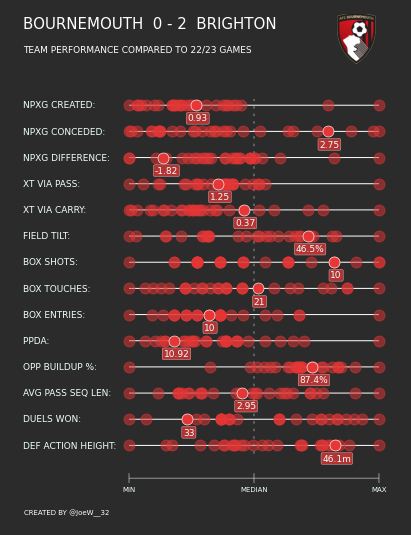

In [152]:
pitch = VerticalPitch(pitch_type='opta', pitch_color='#2B2B2B', line_color='#2B2B2B',pad_top=0, pad_left = 7.5,
                      pad_bottom = 40, pad_right = 80, pitch_width=80, pitch_length=120,
                      linewidth=0.6)

fig, axs = pitch.grid(figheight=8, ncols=1, axis=False, endnote_height=0.02)

fig.set_facecolor("#2B2B2B")
# mpl.rcParams['figure.dpi'] = 800

axs['title'].text(0, 0.8, f'{home_name} {score} { away_name}'.upper(), 
                  ha='left', va='center', color='white',
                  fontsize=15, fontname='Sans Serif')

axs['title'].text(0, 0.5, 
                  "Team Performance compared to 22/23 games".upper(), 
                  ha='left', va='center', color='white',
                  fontsize=9, fontname='Sans Serif')

x_min = 48
x_max = -70
x_diff = x_max-x_min

# NPXG Created
pitch.annotate(text='NPXG Created: '.upper(), 
                      xytext=(98, 100), xy=(0, 0), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
line1 = pitch.lines(98, 50, 98, -68, lw=1, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

min_val = min(xg_created)
max_val = max(xg_created)

for i, val in enumerate(xg_created):
    sf = (val - min_val) / (max_val - min_val)
    x_pos = 50 + x_diff * sf
    
    if i == len(xg_created)-1:
        marker = pitch.scatter(98, x_pos, s=120,
                               color=team_color, linewidth=0.6, marker='o', edgecolor='white', 
                               zorder=2, ax=axs['pitch'])
        pitch.annotate(text=str(round(val,2)), 
                       bbox=dict(facecolor=team_color, edgecolor='white', boxstyle='round,pad=.15', alpha=0.75, 
                                 linewidth=0.4),
                       xytext=(94, x_pos+4), xy=(60, 40), ha='left', va='center',
                       fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
    else:
        pitch.scatter(98, x_pos, s=120,
                      color=team_color, linewidth=1, marker='o', zorder=2, 
                      alpha=0.5, ax=axs['pitch'])
        
        
# NPXG Conceded
pitch.annotate(text='NPXG Conceded: '.upper(), 
                      xytext=(90, 100), xy=(0, 0), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
line1 = pitch.lines(90, 50, 90, -68, lw=1, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

min_val = min(xg_allowed)
max_val = max(xg_allowed)

for i, val in enumerate(xg_allowed):
    sf = (val - min_val) / (max_val - min_val)
    x_pos = 50 + x_diff * sf
    
    if i == len(xg_allowed)-1:
        marker = pitch.scatter(90, x_pos, s=120,
                               color=team_color, linewidth=0.6, marker='o', edgecolor='white', 
                               zorder=2, ax=axs['pitch'])
        pitch.annotate(text=str(round(val,2)), 
                       bbox=dict(facecolor=team_color, edgecolor='white', boxstyle='round,pad=.15', alpha=0.75,
                                 linewidth=0.4),
                       xytext=(86, x_pos+4), xy=(60, 40), ha='left', va='center',
                       fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
    else:
        pitch.scatter(90, x_pos, s=120,
                      color=team_color, linewidth=1, marker='o', zorder=2, 
                      alpha=0.5, ax=axs['pitch'])

# NPXG Difference
pitch.annotate(text='NPXG Difference: '.upper(), 
                      xytext=(82, 100), xy=(0, 0), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
line1 = pitch.lines(82, 50, 82, -68, lw=1, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

min_val = min(xg_diff)
max_val = max(xg_diff)

for i, val in enumerate(xg_diff):
    sf = (val - min_val) / (max_val - min_val)
    x_pos = 50 + x_diff * sf
    
    if i == len(xg_diff)-1:
        marker = pitch.scatter(82, x_pos, s=120,
                               color=team_color, linewidth=0.6, marker='o', edgecolor='white', 
                               zorder=2, ax=axs['pitch'])
        pitch.annotate(text=str(round(val,2)), 
                       bbox=dict(facecolor=team_color, edgecolor='white', boxstyle='round,pad=.15', alpha=0.75,
                                 linewidth=0.4),
                       xytext=(78, x_pos+4), xy=(60, 40), ha='left', va='center',
                       fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
    else:
        pitch.scatter(82, x_pos, s=120,
                      color=team_color, linewidth=1, marker='o', zorder=2, 
                      alpha=0.5, ax=axs['pitch'])


# xT via Pass
pitch.annotate(text='xT via Pass: '.upper(), 
                      xytext=(74, 100), xy=(0, 0), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
line1 = pitch.lines(74, 50, 74, -68, lw=1, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

min_val = min(xt_pass)
max_val = max(xt_pass)

for i, val in enumerate(xt_pass):
    sf = (val - min_val) / (max_val - min_val)
    x_pos = 50 + x_diff * sf
    
    if i == len(xt_pass)-1:
        marker = pitch.scatter(74, x_pos, s=120,
                               color=team_color, linewidth=0.6, marker='o', edgecolor='white', 
                               zorder=2, ax=axs['pitch'])
        pitch.annotate(text=str(round(val,2)), 
                       bbox=dict(facecolor=team_color, edgecolor='white', boxstyle='round,pad=.15', alpha=0.75,
                                 linewidth=0.4),
                       xytext=(70, x_pos+4), xy=(60, 40), ha='left', va='center',
                       fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
    else:
        pitch.scatter(74, x_pos, s=120,
                      color=team_color, linewidth=1, marker='o', zorder=2, 
                      alpha=0.5, ax=axs['pitch'])


# xT via Carry
pitch.annotate(text='xT via Carry: '.upper(), 
                      xytext=(66, 100), xy=(0, 0), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
line1 = pitch.lines(66, 50, 66, -68, lw=1, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

min_val = min(xt_carry)
max_val = max(xt_carry)

for i, val in enumerate(xt_carry):
    sf = (val - min_val) / (max_val - min_val)
    x_pos = 50 + x_diff * sf
    
    if i == len(xt_pass)-1:
        marker = pitch.scatter(66, x_pos, s=120,
                               color=team_color, linewidth=0.6, marker='o', edgecolor='white', 
                               zorder=2, ax=axs['pitch'])
        pitch.annotate(text=str(round(val,2)), 
                       bbox=dict(facecolor=team_color, edgecolor='white', boxstyle='round,pad=.15', alpha=0.75,
                                 linewidth=0.4),
                       xytext=(62, x_pos+4), xy=(60, 40), ha='left', va='center',
                       fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
    else:
        pitch.scatter(66, x_pos, s=120,
                      color=team_color, linewidth=1, marker='o', zorder=2, 
                      alpha=0.5, ax=axs['pitch'])


# Field Tilt
pitch.annotate(text='Field Tilt: '.upper(), 
                      xytext=(58, 100), xy=(0, 0), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
line1 = pitch.lines(58, 50, 58, -68, lw=1, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

min_val = min(field_tilt)
max_val = max(field_tilt)

for i, val in enumerate(field_tilt):
    sf = (val - min_val) / (max_val - min_val)
    x_pos = 50 + x_diff * sf
    
    if i == len(xt_pass)-1:
        marker = pitch.scatter(58, x_pos, s=120,
                               color=team_color, linewidth=0.6, marker='o', edgecolor='white', 
                               zorder=2, ax=axs['pitch'])
        pitch.annotate(text=str(round(val*100,3)) + '%', 
                       bbox=dict(facecolor=team_color, edgecolor='white', boxstyle='round,pad=.15', alpha=0.75, 
                                 linewidth=0.4),
                       xytext=(54, x_pos+6), xy=(60, 40), ha='left', va='center',
                       fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
    else:
        pitch.scatter(58, x_pos, s=120,
                      color=team_color, linewidth=1, marker='o', zorder=2, 
                      alpha=0.5, ax=axs['pitch'])


# Box Shots
pitch.annotate(text='Box Shots: '.upper(), 
                      xytext=(50, 100), xy=(0, 0), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
line1 = pitch.lines(50, 50, 50, -68, lw=1, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

min_val = min(box_shots)
max_val = max(box_shots)

for i, val in enumerate(box_shots):
    sf = (val - min_val) / (max_val - min_val)
    x_pos = 50 + x_diff * sf
    
    if i == len(xt_pass)-1:
        marker = pitch.scatter(50, x_pos, s=120,
                               color=team_color, linewidth=0.6, marker='o', edgecolor='white', 
                               zorder=2, ax=axs['pitch'])
        pitch.annotate(text=str(val), 
                       bbox=dict(facecolor=team_color, edgecolor='white', boxstyle='round,pad=.15', alpha=0.75,
                                 linewidth=0.4),
                       xytext=(46, x_pos+1.5), xy=(60, 40), ha='left', va='center',
                       fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
    else:
        pitch.scatter(50, x_pos, s=120,
                      color=team_color, linewidth=1, marker='o', zorder=2, 
                      alpha=0.5, ax=axs['pitch'])


# Box Touches 
pitch.annotate(text='Box Touches: '.upper(), 
                      xytext=(42, 100), xy=(0, 0), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
line1 = pitch.lines(42, 50, 42, -68, lw=1, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

min_val = min(box_touches)
max_val = max(box_touches)

for i, val in enumerate(box_touches):
    sf = (val - min_val) / (max_val - min_val)
    x_pos = 50 + x_diff * sf
    
    if i == len(xt_pass)-1:
        marker = pitch.scatter(42, x_pos, s=120,
                               color=team_color, linewidth=0.6, marker='o', edgecolor='white', 
                               zorder=2, ax=axs['pitch'])
        pitch.annotate(text=str(val), 
                       bbox=dict(facecolor=team_color, edgecolor='white', boxstyle='round,pad=.15', alpha=0.75,
                                 linewidth=0.4),
                       xytext=(38, x_pos+2), xy=(60, 40), ha='left', va='center',
                       fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
    else:
        pitch.scatter(42, x_pos, s=120,
                      color=team_color, linewidth=1, marker='o', zorder=2, 
                      alpha=0.5, ax=axs['pitch'])


# Box Entries
pitch.annotate(text='Box Entries: '.upper(), 
                      xytext=(34, 100), xy=(0, 0), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
line1 = pitch.lines(34, 50, 34, -68, lw=1, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

min_val = min(box_entries)
max_val = max(box_entries)

for i, val in enumerate(box_entries):
    sf = (val - min_val) / (max_val - min_val)
    x_pos = 50 + x_diff * sf
    
    if i == len(xt_pass)-1:
        marker = pitch.scatter(34, x_pos, s=120,
                               color=team_color, linewidth=0.6, marker='o', edgecolor='white', 
                               zorder=2, ax=axs['pitch'])
        pitch.annotate(text=str(val), 
                       bbox=dict(facecolor=team_color, edgecolor='white', boxstyle='round,pad=.15', alpha=0.75,
                                 linewidth=0.4),
                       xytext=(30, x_pos+2), xy=(60, 40), ha='left', va='center',
                       fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
    else:
        pitch.scatter(34, x_pos, s=120,
                      color=team_color, linewidth=1, marker='o', zorder=2, 
                      alpha=0.5, ax=axs['pitch'])


# PPDA
pitch.annotate(text='PPDA: '.upper(), 
                      xytext=(26, 100), xy=(0, 0), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
line1 = pitch.lines(26, 50, 26, -68, lw=1, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

min_val = min(ppda)
max_val = max(ppda)

for i, val in enumerate(ppda):
    sf = (val - min_val) / (max_val - min_val)
    x_pos = 50 + x_diff * sf
    
    if i == len(xt_pass)-1:
        marker = pitch.scatter(26, x_pos, s=120,
                               color=team_color, linewidth=0.6, marker='o', edgecolor='white', 
                               zorder=2, ax=axs['pitch'])
        pitch.annotate(text=str(val), 
                       bbox=dict(facecolor=team_color, edgecolor='white', boxstyle='round,pad=.15', alpha=0.75, 
                                 linewidth=0.4),
                       xytext=(22, x_pos+5), xy=(60, 40), ha='left', va='center',
                       fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
    else:
        pitch.scatter(26, x_pos, s=120,
                      color=team_color, linewidth=1, marker='o', zorder=2, 
                      alpha=0.5, ax=axs['pitch'])


# Opp Buildup
pitch.annotate(text='Opp Buildup %: '.upper(), 
                      xytext=(18, 100), xy=(0, 0), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
line1 = pitch.lines(18, 50, 18, -68, lw=1, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

min_val = min(opp_buildup)
max_val = max(opp_buildup)

for i, val in enumerate(opp_buildup):
    sf = (val - min_val) / (max_val - min_val)
    x_pos = 50 + x_diff * sf
    
    if i == len(xt_pass)-1:
        marker = pitch.scatter(18, x_pos, s=120,
                               color=team_color, linewidth=0.6, marker='o', edgecolor='white', 
                               zorder=2, ax=axs['pitch'])
        pitch.annotate(text=str(round(val*100,1)) + '%',  
                       bbox=dict(facecolor=team_color, edgecolor='white', boxstyle='round,pad=.15', alpha=0.75,
                                 linewidth=0.4),
                       xytext=(14, x_pos+6), xy=(60, 40), ha='left', va='center',
                       fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
    else:
        pitch.scatter(18, x_pos, s=120,
                      color=team_color, linewidth=1, marker='o', zorder=2, 
                      alpha=0.5, ax=axs['pitch'])


# Avg Pass Seq Len
pitch.annotate(text='Avg Pass Seq Len: '.upper(), 
                      xytext=(10, 100), xy=(0, 0), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
line1 = pitch.lines(10, 50, 10, -68, lw=1, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

min_val = min(avg_seq_len)
max_val = max(avg_seq_len)

for i, val in enumerate(avg_seq_len):
    sf = (val - min_val) / (max_val - min_val)
    x_pos = 50 + x_diff * sf
    
    if i == len(xt_pass)-1:
        marker = pitch.scatter(10, x_pos, s=120,
                               color=team_color, linewidth=0.6, marker='o', edgecolor='white', 
                               zorder=2, ax=axs['pitch'])
        pitch.annotate(text=str(round(val,2)), 
                       bbox=dict(facecolor=team_color, edgecolor='white', boxstyle='round,pad=.15', alpha=0.75, 
                                 linewidth=0.4),
                       xytext=(6, x_pos+3), xy=(60, 40), ha='left', va='center',
                       fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
    else:
        pitch.scatter(10, x_pos, s=120,
                      color=team_color, linewidth=1, marker='o', zorder=2, 
                      alpha=0.5, ax=axs['pitch'])

        
# Duels Won
pitch.annotate(text='Duels Won: '.upper(), 
                      xytext=(2, 100), xy=(0, 0), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
line1 = pitch.lines(2, 50, 2, -68, lw=1, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

min_val = min(duels_won)
max_val = max(duels_won)

for i, val in enumerate(duels_won):
    sf = (val - min_val) / (max_val - min_val)
    x_pos = 50 + x_diff * sf
    
    if i == len(xt_pass)-1:
        marker = pitch.scatter(2, x_pos, s=120,
                               color=team_color, linewidth=0.6, marker='o', edgecolor='white', 
                               zorder=2, ax=axs['pitch'])
        pitch.annotate(text=str(val), 
                       bbox=dict(facecolor=team_color, edgecolor='white', boxstyle='round,pad=.15', alpha=0.75,
                                 linewidth=0.4),
                       xytext=(-2, x_pos+2), xy=(60, 40), ha='left', va='center',
                       fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
    else:
        pitch.scatter(2, x_pos, s=120,
                      color=team_color, linewidth=1, marker='o', zorder=2, 
                      alpha=0.5, ax=axs['pitch'])


# Def Action Height
pitch.annotate(text='Def Action Height: '.upper(), 
                      xytext=(-6, 100), xy=(0, 0), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
line1 = pitch.lines(-6, 50, -6, -68, lw=1, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

min_val = min(def_action_height)
max_val = max(def_action_height)

for i, val in enumerate(def_action_height):
    sf = (val - min_val) / (max_val - min_val)
    x_pos = 50 + x_diff * sf
    
    if i == len(xt_pass)-1:
        marker = pitch.scatter(-6, x_pos, s=120,
                               color=team_color, linewidth=0.6, marker='o', edgecolor='white', 
                               zorder=2, ax=axs['pitch'])
        pitch.annotate(text=str(round(val,1))+'m', 
                       bbox=dict(facecolor=team_color, edgecolor='white', boxstyle='round,pad=.15', alpha=0.75,
                                 linewidth=0.4),
                       xytext=(-10, x_pos+6), xy=(60, 40), ha='left', va='center',
                       fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
    else:
        pitch.scatter(-6, x_pos, s=120,
                      color=team_color, linewidth=1, marker='o', zorder=2, 
                      alpha=0.5, ax=axs['pitch'])


fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
team_logos2 = team_code
club_icon2 = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_logos2:.0f}.png'))
newax2 = fig.add_axes([0.8,0.82, 0.12, 0.12], anchor='NE', zorder=2)
newax2.imshow(club_icon2)
newax2.axis('off')

plt.figtext(0.065, 0.07, "CREATED BY @JoeW__32", ha="left", fontsize=7, fontname='Sans Serif', color='white')

# Dashed Line
line1 = pitch.lines(100, -9, -10, -9, lw=0.5, color='white',
                    zorder=1, linestyle=(0,(5,10)), ax=axs['pitch'])

# Horizontal Bottom Line
line1 = pitch.lines(-16, 50, -16, -68, lw=0.5, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

# Min
line1 = pitch.lines(-14.5, 50, -17.5, 50, lw=0.5, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])
pitch.annotate(text='MIN', 
                      xytext=(-19.5, 50), xy=(0, 0), ha='center', va='center',
                      fontname = 'Sans Serif', fontsize=7, color='azure', ax=axs['pitch'])

# Median
line1 = pitch.lines(-14.5, -68, -17.5, -68, lw=0.5, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])
pitch.annotate(text='MEDIAN', 
                      xytext=(-19.5, -9), xy=(0, 0), ha='center', va='center',
                      fontname = 'Sans Serif', fontsize=7, color='azure', ax=axs['pitch'])

# Max
line1 = pitch.lines(-14.5, -9, -17.5, -9, lw=0.5, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])
pitch.annotate(text='MAX', 
                      xytext=(-19.5, -68), xy=(0, 0), ha='center', va='center',
                      fontname = 'Sans Serif', fontsize=7, color='azure', ax=axs['pitch'])

fig.savefig('homeTeam.png', 
            bbox_inches="tight",
            edgecolor="none",
            dpi=600)

## For Away_Team 

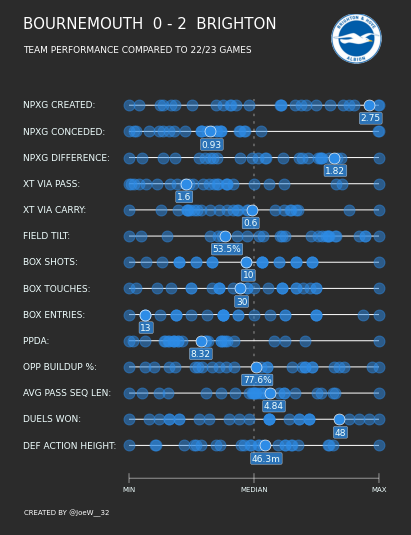

In [153]:
teamID = mapping[away_name]
team_color = home_colors[away_name]
team_code = logos[away_name]

df1 = pd.read_csv('pl_2223_FirstHalf.csv').iloc[:,1:]
matches1 = df1[df1['teamId'] == teamID]['matchId'].unique()

df2 = pd.read_csv('pl_2223_SecondHalf.csv').iloc[:,1:]
matches2 = df2[df2['teamId'] == teamID]['matchId'].unique()

df1 = df1[df1['matchId'].isin(matches1)].reset_index(drop=True)
df2 = df2[df2['matchId'].isin(matches2)].reset_index(drop=True)


main_id = mapping[away_name]
xg_created = []
xg_allowed = []
xg_diff = []
xt_pass = []
xt_carry = []
field_tilt = []
box_shots = []
box_touches = []
box_entries = []
ppda = []
opp_buildup = []
avg_seq_len = []
duels_won = []
def_action_height = []

for match_id in matches1:
    df = df1[df1['matchId'] == match_id].reset_index(drop=True)
    ids = df['teamId'].unique()
    opp_id = [id_ for id_ in ids if id_ != main_id][0]
    
    xg = xg_calc(df)
    xg_create = xg[main_id]
    xg_allow = xg[opp_id]
    npxg_diff = xg_create - xg_allow
    
    xt_via_pass = xT_pass(df, main_id)
    xt_via_carry = xT_carry(df, main_id)
    
    field_tilt_match = round(fieldTilt(df, main_id, opp_id),3)
    
    boxShots = box_shots_(df, main_id)
    
    box_touch_count = boxTouches(df, main_id)
    box_entries_count = boxEntries(df, main_id)
    
    ppda_game = PPDA(df, main_id, opp_id)
    opp_buildup_game = OPP_BUILDUP(df, opp_id)
    
    avg_seq_len_game = AVG_SEQ_LEN(df, main_id)
    
    duels_won_game = DUELS_WON(df, main_id)
    
    def_action_height_game = DEF_ACTION_HEIGHT(df, main_id)
    
    xg_diff.append(npxg_diff)
    xg_created.append(xg_create)
    xg_allowed.append(xg_allow)
    xt_pass.append(xt_via_pass)
    xt_carry.append(xt_via_carry)
    field_tilt.append(field_tilt_match)
    box_shots.append(boxShots)
    box_touches.append(box_touch_count)
    box_entries.append(box_entries_count)
    ppda.append(ppda_game)
    opp_buildup.append(opp_buildup_game)
    avg_seq_len.append(avg_seq_len_game)
    duels_won.append(duels_won_game)
    def_action_height.append(def_action_height_game)
    
for match_id in matches2:
    df = df2[df2['matchId'] == match_id].reset_index(drop=True)
    ids = df['teamId'].unique()
    opp_id = [id_ for id_ in ids if id_ != main_id][0]
    
    xg = xg_calc(df)
    xg_create = xg[main_id]
    xg_allow = xg[opp_id]
    npxg_diff = xg_create - xg_allow
    
    xt_via_pass = xT_pass(df, main_id)
    xt_via_carry = xT_carry(df, main_id)
    
    field_tilt_match = round(fieldTilt(df, main_id, opp_id),3)
    
    boxShots = box_shots_(df, main_id)
    
    box_touch_count = boxTouches(df, main_id)
    box_entries_count = boxEntries(df, main_id)
    
    ppda_game = PPDA(df, main_id, opp_id)
    opp_buildup_game = OPP_BUILDUP(df, opp_id)
    
    avg_seq_len_game = AVG_SEQ_LEN(df, main_id)
    
    duels_won_game = DUELS_WON(df, main_id)
    
    def_action_height_game = DEF_ACTION_HEIGHT(df, main_id)
    
    xg_diff.append(npxg_diff)
    xg_created.append(xg_create)
    xg_allowed.append(xg_allow)
    xt_pass.append(xt_via_pass)
    xt_carry.append(xt_via_carry)
    field_tilt.append(field_tilt_match)
    box_shots.append(boxShots)
    box_touches.append(box_touch_count)
    box_entries.append(box_entries_count)
    ppda.append(ppda_game)
    opp_buildup.append(opp_buildup_game)
    avg_seq_len.append(avg_seq_len_game)
    duels_won.append(duels_won_game)
    def_action_height.append(def_action_height_game)
    
    
pitch = VerticalPitch(pitch_type='opta', pitch_color='#2B2B2B', line_color='#2B2B2B',pad_top=0, pad_left = 7.5,
                      pad_bottom = 40, pad_right = 80, pitch_width=80, pitch_length=120,
                      linewidth=0.6)

fig, axs = pitch.grid(figheight=8, ncols=1, axis=False, endnote_height=0.02)

fig.set_facecolor("#2B2B2B")
# mpl.rcParams['figure.dpi'] = 800

axs['title'].text(0, 0.8, f'{home_name} {score} { away_name}'.upper(), 
                  ha='left', va='center', color='white',
                  fontsize=15, fontname='Sans Serif')

axs['title'].text(0, 0.5, 
                  "Team Performance compared to 22/23 games".upper(), 
                  ha='left', va='center', color='white',
                  fontsize=9, fontname='Sans Serif')

x_min = 48
x_max = -70
x_diff = x_max-x_min

# NPXG Created
pitch.annotate(text='NPXG Created: '.upper(), 
                      xytext=(98, 100), xy=(0, 0), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
line1 = pitch.lines(98, 50, 98, -68, lw=1, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

min_val = min(xg_created)
max_val = max(xg_created)

for i, val in enumerate(xg_created):
    sf = (val - min_val) / (max_val - min_val)
    x_pos = 50 + x_diff * sf
    
    if i == len(xg_created)-1:
        marker = pitch.scatter(98, x_pos, s=120,
                               color=team_color, linewidth=0.6, marker='o', edgecolor='white', 
                               zorder=2, ax=axs['pitch'])
        pitch.annotate(text=str(round(val,2)), 
                       bbox=dict(facecolor=team_color, edgecolor='white', boxstyle='round,pad=.15', alpha=0.75, 
                                 linewidth=0.4),
                       xytext=(94, x_pos+4), xy=(60, 40), ha='left', va='center',
                       fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
    else:
        pitch.scatter(98, x_pos, s=120,
                      color=team_color, linewidth=1, marker='o', zorder=2, 
                      alpha=0.5, ax=axs['pitch'])
        
        
# NPXG Conceded
pitch.annotate(text='NPXG Conceded: '.upper(), 
                      xytext=(90, 100), xy=(0, 0), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
line1 = pitch.lines(90, 50, 90, -68, lw=1, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

min_val = min(xg_allowed)
max_val = max(xg_allowed)

for i, val in enumerate(xg_allowed):
    sf = (val - min_val) / (max_val - min_val)
    x_pos = 50 + x_diff * sf
    
    if i == len(xg_allowed)-1:
        marker = pitch.scatter(90, x_pos, s=120,
                               color=team_color, linewidth=0.6, marker='o', edgecolor='white', 
                               zorder=2, ax=axs['pitch'])
        pitch.annotate(text=str(round(val,2)), 
                       bbox=dict(facecolor=team_color, edgecolor='white', boxstyle='round,pad=.15', alpha=0.75,
                                 linewidth=0.4),
                       xytext=(86, x_pos+4), xy=(60, 40), ha='left', va='center',
                       fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
    else:
        pitch.scatter(90, x_pos, s=120,
                      color=team_color, linewidth=1, marker='o', zorder=2, 
                      alpha=0.5, ax=axs['pitch'])

# NPXG Difference
pitch.annotate(text='NPXG Difference: '.upper(), 
                      xytext=(82, 100), xy=(0, 0), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
line1 = pitch.lines(82, 50, 82, -68, lw=1, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

min_val = min(xg_diff)
max_val = max(xg_diff)

for i, val in enumerate(xg_diff):
    sf = (val - min_val) / (max_val - min_val)
    x_pos = 50 + x_diff * sf
    
    if i == len(xg_diff)-1:
        marker = pitch.scatter(82, x_pos, s=120,
                               color=team_color, linewidth=0.6, marker='o', edgecolor='white', 
                               zorder=2, ax=axs['pitch'])
        pitch.annotate(text=str(round(val,2)), 
                       bbox=dict(facecolor=team_color, edgecolor='white', boxstyle='round,pad=.15', alpha=0.75,
                                 linewidth=0.4),
                       xytext=(78, x_pos+4), xy=(60, 40), ha='left', va='center',
                       fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
    else:
        pitch.scatter(82, x_pos, s=120,
                      color=team_color, linewidth=1, marker='o', zorder=2, 
                      alpha=0.5, ax=axs['pitch'])


# xT via Pass
pitch.annotate(text='xT via Pass: '.upper(), 
                      xytext=(74, 100), xy=(0, 0), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
line1 = pitch.lines(74, 50, 74, -68, lw=1, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

min_val = min(xt_pass)
max_val = max(xt_pass)

for i, val in enumerate(xt_pass):
    sf = (val - min_val) / (max_val - min_val)
    x_pos = 50 + x_diff * sf
    
    if i == len(xt_pass)-1:
        marker = pitch.scatter(74, x_pos, s=120,
                               color=team_color, linewidth=0.6, marker='o', edgecolor='white', 
                               zorder=2, ax=axs['pitch'])
        pitch.annotate(text=str(round(val,2)), 
                       bbox=dict(facecolor=team_color, edgecolor='white', boxstyle='round,pad=.15', alpha=0.75,
                                 linewidth=0.4),
                       xytext=(70, x_pos+4), xy=(60, 40), ha='left', va='center',
                       fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
    else:
        pitch.scatter(74, x_pos, s=120,
                      color=team_color, linewidth=1, marker='o', zorder=2, 
                      alpha=0.5, ax=axs['pitch'])


# xT via Carry
pitch.annotate(text='xT via Carry: '.upper(), 
                      xytext=(66, 100), xy=(0, 0), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
line1 = pitch.lines(66, 50, 66, -68, lw=1, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

min_val = min(xt_carry)
max_val = max(xt_carry)

for i, val in enumerate(xt_carry):
    sf = (val - min_val) / (max_val - min_val)
    x_pos = 50 + x_diff * sf
    
    if i == len(xt_pass)-1:
        marker = pitch.scatter(66, x_pos, s=120,
                               color=team_color, linewidth=0.6, marker='o', edgecolor='white', 
                               zorder=2, ax=axs['pitch'])
        pitch.annotate(text=str(round(val,2)), 
                       bbox=dict(facecolor=team_color, edgecolor='white', boxstyle='round,pad=.15', alpha=0.75,
                                 linewidth=0.4),
                       xytext=(62, x_pos+4), xy=(60, 40), ha='left', va='center',
                       fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
    else:
        pitch.scatter(66, x_pos, s=120,
                      color=team_color, linewidth=1, marker='o', zorder=2, 
                      alpha=0.5, ax=axs['pitch'])


# Field Tilt
pitch.annotate(text='Field Tilt: '.upper(), 
                      xytext=(58, 100), xy=(0, 0), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
line1 = pitch.lines(58, 50, 58, -68, lw=1, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

min_val = min(field_tilt)
max_val = max(field_tilt)

for i, val in enumerate(field_tilt):
    sf = (val - min_val) / (max_val - min_val)
    x_pos = 50 + x_diff * sf
    
    if i == len(xt_pass)-1:
        marker = pitch.scatter(58, x_pos, s=120,
                               color=team_color, linewidth=0.6, marker='o', edgecolor='white', 
                               zorder=2, ax=axs['pitch'])
        pitch.annotate(text=str(round(val*100,3)) + '%', 
                       bbox=dict(facecolor=team_color, edgecolor='white', boxstyle='round,pad=.15', alpha=0.75, 
                                 linewidth=0.4),
                       xytext=(54, x_pos+6), xy=(60, 40), ha='left', va='center',
                       fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
    else:
        pitch.scatter(58, x_pos, s=120,
                      color=team_color, linewidth=1, marker='o', zorder=2, 
                      alpha=0.5, ax=axs['pitch'])


# Box Shots
pitch.annotate(text='Box Shots: '.upper(), 
                      xytext=(50, 100), xy=(0, 0), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
line1 = pitch.lines(50, 50, 50, -68, lw=1, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

min_val = min(box_shots)
max_val = max(box_shots)

for i, val in enumerate(box_shots):
    sf = (val - min_val) / (max_val - min_val)
    x_pos = 50 + x_diff * sf
    
    if i == len(xt_pass)-1:
        marker = pitch.scatter(50, x_pos, s=120,
                               color=team_color, linewidth=0.6, marker='o', edgecolor='white', 
                               zorder=2, ax=axs['pitch'])
        pitch.annotate(text=str(val), 
                       bbox=dict(facecolor=team_color, edgecolor='white', boxstyle='round,pad=.15', alpha=0.75,
                                 linewidth=0.4),
                       xytext=(46, x_pos+1.5), xy=(60, 40), ha='left', va='center',
                       fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
    else:
        pitch.scatter(50, x_pos, s=120,
                      color=team_color, linewidth=1, marker='o', zorder=2, 
                      alpha=0.5, ax=axs['pitch'])


# Box Touches 
pitch.annotate(text='Box Touches: '.upper(), 
                      xytext=(42, 100), xy=(0, 0), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
line1 = pitch.lines(42, 50, 42, -68, lw=1, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

min_val = min(box_touches)
max_val = max(box_touches)

for i, val in enumerate(box_touches):
    sf = (val - min_val) / (max_val - min_val)
    x_pos = 50 + x_diff * sf
    
    if i == len(xt_pass)-1:
        marker = pitch.scatter(42, x_pos, s=120,
                               color=team_color, linewidth=0.6, marker='o', edgecolor='white', 
                               zorder=2, ax=axs['pitch'])
        pitch.annotate(text=str(val), 
                       bbox=dict(facecolor=team_color, edgecolor='white', boxstyle='round,pad=.15', alpha=0.75,
                                 linewidth=0.4),
                       xytext=(38, x_pos+2), xy=(60, 40), ha='left', va='center',
                       fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
    else:
        pitch.scatter(42, x_pos, s=120,
                      color=team_color, linewidth=1, marker='o', zorder=2, 
                      alpha=0.5, ax=axs['pitch'])


# Box Entries
pitch.annotate(text='Box Entries: '.upper(), 
                      xytext=(34, 100), xy=(0, 0), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
line1 = pitch.lines(34, 50, 34, -68, lw=1, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

min_val = min(box_entries)
max_val = max(box_entries)

for i, val in enumerate(box_entries):
    sf = (val - min_val) / (max_val - min_val)
    x_pos = 50 + x_diff * sf
    
    if i == len(xt_pass)-1:
        marker = pitch.scatter(34, x_pos, s=120,
                               color=team_color, linewidth=0.6, marker='o', edgecolor='white', 
                               zorder=2, ax=axs['pitch'])
        pitch.annotate(text=str(val), 
                       bbox=dict(facecolor=team_color, edgecolor='white', boxstyle='round,pad=.15', alpha=0.75,
                                 linewidth=0.4),
                       xytext=(30, x_pos+2), xy=(60, 40), ha='left', va='center',
                       fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
    else:
        pitch.scatter(34, x_pos, s=120,
                      color=team_color, linewidth=1, marker='o', zorder=2, 
                      alpha=0.5, ax=axs['pitch'])


# PPDA
pitch.annotate(text='PPDA: '.upper(), 
                      xytext=(26, 100), xy=(0, 0), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
line1 = pitch.lines(26, 50, 26, -68, lw=1, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

min_val = min(ppda)
max_val = max(ppda)

for i, val in enumerate(ppda):
    sf = (val - min_val) / (max_val - min_val)
    x_pos = 50 + x_diff * sf
    
    if i == len(xt_pass)-1:
        marker = pitch.scatter(26, x_pos, s=120,
                               color=team_color, linewidth=0.6, marker='o', edgecolor='white', 
                               zorder=2, ax=axs['pitch'])
        pitch.annotate(text=str(val), 
                       bbox=dict(facecolor=team_color, edgecolor='white', boxstyle='round,pad=.15', alpha=0.75, 
                                 linewidth=0.4),
                       xytext=(22, x_pos+5), xy=(60, 40), ha='left', va='center',
                       fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
    else:
        pitch.scatter(26, x_pos, s=120,
                      color=team_color, linewidth=1, marker='o', zorder=2, 
                      alpha=0.5, ax=axs['pitch'])


# Opp Buildup
pitch.annotate(text='Opp Buildup %: '.upper(), 
                      xytext=(18, 100), xy=(0, 0), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
line1 = pitch.lines(18, 50, 18, -68, lw=1, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

min_val = min(opp_buildup)
max_val = max(opp_buildup)

for i, val in enumerate(opp_buildup):
    sf = (val - min_val) / (max_val - min_val)
    x_pos = 50 + x_diff * sf
    
    if i == len(xt_pass)-1:
        marker = pitch.scatter(18, x_pos, s=120,
                               color=team_color, linewidth=0.6, marker='o', edgecolor='white', 
                               zorder=2, ax=axs['pitch'])
        pitch.annotate(text=str(round(val*100,1)) + '%',  
                       bbox=dict(facecolor=team_color, edgecolor='white', boxstyle='round,pad=.15', alpha=0.75,
                                 linewidth=0.4),
                       xytext=(14, x_pos+6), xy=(60, 40), ha='left', va='center',
                       fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
    else:
        pitch.scatter(18, x_pos, s=120,
                      color=team_color, linewidth=1, marker='o', zorder=2, 
                      alpha=0.5, ax=axs['pitch'])


# Avg Pass Seq Len
pitch.annotate(text='Avg Pass Seq Len: '.upper(), 
                      xytext=(10, 100), xy=(0, 0), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
line1 = pitch.lines(10, 50, 10, -68, lw=1, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

min_val = min(avg_seq_len)
max_val = max(avg_seq_len)

for i, val in enumerate(avg_seq_len):
    sf = (val - min_val) / (max_val - min_val)
    x_pos = 50 + x_diff * sf
    
    if i == len(xt_pass)-1:
        marker = pitch.scatter(10, x_pos, s=120,
                               color=team_color, linewidth=0.6, marker='o', edgecolor='white', 
                               zorder=2, ax=axs['pitch'])
        pitch.annotate(text=str(round(val,2)), 
                       bbox=dict(facecolor=team_color, edgecolor='white', boxstyle='round,pad=.15', alpha=0.75, 
                                 linewidth=0.4),
                       xytext=(6, x_pos+3), xy=(60, 40), ha='left', va='center',
                       fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
    else:
        pitch.scatter(10, x_pos, s=120,
                      color=team_color, linewidth=1, marker='o', zorder=2, 
                      alpha=0.5, ax=axs['pitch'])

        
# Duels Won
pitch.annotate(text='Duels Won: '.upper(), 
                      xytext=(2, 100), xy=(0, 0), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
line1 = pitch.lines(2, 50, 2, -68, lw=1, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

min_val = min(duels_won)
max_val = max(duels_won)

for i, val in enumerate(duels_won):
    sf = (val - min_val) / (max_val - min_val)
    x_pos = 50 + x_diff * sf
    
    if i == len(xt_pass)-1:
        marker = pitch.scatter(2, x_pos, s=120,
                               color=team_color, linewidth=0.6, marker='o', edgecolor='white', 
                               zorder=2, ax=axs['pitch'])
        pitch.annotate(text=str(val), 
                       bbox=dict(facecolor=team_color, edgecolor='white', boxstyle='round,pad=.15', alpha=0.75,
                                 linewidth=0.4),
                       xytext=(-2, x_pos+2), xy=(60, 40), ha='left', va='center',
                       fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
    else:
        pitch.scatter(2, x_pos, s=120,
                      color=team_color, linewidth=1, marker='o', zorder=2, 
                      alpha=0.5, ax=axs['pitch'])


# Def Action Height
pitch.annotate(text='Def Action Height: '.upper(), 
                      xytext=(-6, 100), xy=(0, 0), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
line1 = pitch.lines(-6, 50, -6, -68, lw=1, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

min_val = min(def_action_height)
max_val = max(def_action_height)

for i, val in enumerate(def_action_height):
    sf = (val - min_val) / (max_val - min_val)
    x_pos = 50 + x_diff * sf
    
    if i == len(xt_pass)-1:
        marker = pitch.scatter(-6, x_pos, s=120,
                               color=team_color, linewidth=0.6, marker='o', edgecolor='white', 
                               zorder=2, ax=axs['pitch'])
        pitch.annotate(text=str(round(val,1))+'m', 
                       bbox=dict(facecolor=team_color, edgecolor='white', boxstyle='round,pad=.15', alpha=0.75,
                                 linewidth=0.4),
                       xytext=(-10, x_pos+6), xy=(60, 40), ha='left', va='center',
                       fontname = 'Sans Serif', fontsize=9, color='azure', ax=axs['pitch'])
    else:
        pitch.scatter(-6, x_pos, s=120,
                      color=team_color, linewidth=1, marker='o', zorder=2, 
                      alpha=0.5, ax=axs['pitch'])


fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
team_logos2 = team_code
club_icon2 = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_logos2:.0f}.png'))
newax2 = fig.add_axes([0.8,0.82, 0.12, 0.12], anchor='NE', zorder=2)
newax2.imshow(club_icon2)
newax2.axis('off')

plt.figtext(0.065, 0.07, "CREATED BY @JoeW__32", ha="left", fontsize=7, fontname='Sans Serif', color='white')

# Dashed Line
line1 = pitch.lines(100, -9, -10, -9, lw=0.5, color='white',
                    zorder=1, linestyle=(0,(5,10)), ax=axs['pitch'])

# Horizontal Bottom Line
line1 = pitch.lines(-16, 50, -16, -68, lw=0.5, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])

# Min
line1 = pitch.lines(-14.5, 50, -17.5, 50, lw=0.5, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])
pitch.annotate(text='MIN', 
                      xytext=(-19.5, 50), xy=(0, 0), ha='center', va='center',
                      fontname = 'Sans Serif', fontsize=7, color='azure', ax=axs['pitch'])

# Median
line1 = pitch.lines(-14.5, -68, -17.5, -68, lw=0.5, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])
pitch.annotate(text='MEDIAN', 
                      xytext=(-19.5, -9), xy=(0, 0), ha='center', va='center',
                      fontname = 'Sans Serif', fontsize=7, color='azure', ax=axs['pitch'])

# Max
line1 = pitch.lines(-14.5, -9, -17.5, -9, lw=0.5, color='white',
                    zorder=1, linestyle='-', ax=axs['pitch'])
pitch.annotate(text='MAX', 
                      xytext=(-19.5, -68), xy=(0, 0), ha='center', va='center',
                      fontname = 'Sans Serif', fontsize=7, color='azure', ax=axs['pitch'])

fig.savefig('awayTeam.png', 
            bbox_inches="tight",
            edgecolor="none",
            dpi=600)
